Plot seasonal cycles of WTEs frequency and monthly rainfall (Fig. 1c)

In [1]:
import sys
import os
import argparse
import pickle
import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib as mpl

from matplotlib.lines import Line2D
from matplotlib.patches import Circle
from matplotlib.colors import BoundaryNorm, Normalize

from config import *
from CP4.utils.make_shapes import *
from CP4.utils.make_colorbar import MidpointNormalize
from CP4.make_climato.compute_monthly_mean_var import load_var_monthly_mean
from CP4.make_composites.a1_make_var_field import *
from CP4.make_composites.b1_make_var_field_anomaly import load_composite_mean_ano_field
from CP4.plots.p_config import *

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [2]:
ds='CP4A'
res=4
var_ref='twb'
var='twb'
window=6
y0=1997
y1=2006
months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
q_thresh=0.95
t_thresh=26.
min_hw_size=100.  # km2
max_hw_size=1000000.  # km2
sw=[4., 4.]
tw=[-72, 72]
samtime=[12, 12]
n_days=3
meth='cc3d'
cnty=26
regs=['WSahel', 'CSahel', 'ESahel', 'Guinea', 'CAfr']
flabel='c'

In [3]:
years = np.arange(y0, y1+1, 1)
years_ = str(y0) + '-' + str(y1)
months_ = "-".join([str(m) for m in months])

res_ = str(res) + 'km'

swlat = sw[0]
swlon = sw[1]
sw_ = str(swlat) + 'x' + str(swlon)

regs_sahel = [reg for reg in regs if 'Sahel' in reg]

In [4]:
#~ Get data

out_rclim = []
for y in years:
    rclim = load_var_monthly_mean(ds, res, 'lsRain', y, months)
    out_rclim.append(rclim)

out_rclim = xr.concat(out_rclim, dim='time')
out_rclim_mean = out_rclim.groupby("time.month").mean()

out_dates = []
out_months = pd.DataFrame(columns=regs, index=months)
out_n_hhee = []
out_rain_regs = {}

for reg in regs:
    coords = study_regions[reg]
    lat_range = coords[0]
    lon_range = coords[1]

    out_rain_regs[reg] = out_rclim_mean.sel(latitude=slice(lat_range[0]+sw[0]/2, lat_range[1]-sw[0]/2), longitude=slice(lon_range[0]+sw[1]/2, lon_range[1]-sw[1]/2)).mean(dim='latitude').mean(dim='longitude') * 3600 * 24 * 30

    dates = load_composite_dates_hhee(ds, res, var_ref, y0, y1, months, t_thresh, q_thresh, n_days, window, sw, tw, lat_range, lon_range, min_hw_size, max_hw_size, meth, cnty)

    features = load_composite_features_hhee(ds, res, var_ref, y0, y1, months, t_thresh, q_thresh, n_days, window, sw, tw, lat_range, lon_range, min_hw_size, max_hw_size, meth, cnty)

    months_hhee = [int(d[5:7]) for d in dates]
    mths, counts = np.unique(months_hhee, return_counts=True)
    df_mths = pd.Series(index=months)
    df_mths.loc[mths] = counts
    df_mths.fillna(0., inplace=True)

    out_dates.append(dates)
    out_months[reg] = df_mths
    out_n_hhee.append(pd.Series(features.shape[0]))

In [5]:
#~ Treat data

df_rain = pd.DataFrame(data=out_rain_regs)
df_rain['Sahel'] = df_rain[regs_sahel].mean(axis=1)
df_rain.drop(regs_sahel, axis=1, inplace=True)

df_rain = df_rain[['Sahel', 'Guinea', 'CAfr']]
df_rain.index = months

out_dates = [d for date in out_dates for d in date]
out_n_hhee = pd.concat(out_n_hhee, axis=1)

out_n_hhee.columns = regs
out_n_hhee['Sahel'] = out_n_hhee[regs_sahel].sum(axis=1)

out_months['Sahel'] = out_months[regs_sahel].sum(axis=1)
out_months.drop(regs_sahel, axis=1, inplace=True)

out_months = out_months[['Sahel', 'Guinea', 'CAfr']]
out_months_rel = out_months / out_months.sum() * 100

out_n_hhee.drop(regs_sahel, axis=1, inplace=True)
out_n_hhee = out_n_hhee[['Sahel', 'Guinea', 'CAfr']]

mths_mean_rel = (out_months_rel*out_n_hhee.values).sum(axis=1) / out_n_hhee.sum(axis=1).values


months_hhee = [int(d[5:7]) for d in out_dates]
mths, counts = np.unique(months_hhee, return_counts=True)
df_mths = pd.Series(index=np.arange(months[0], months[-1]+1, 1))
df_mths.loc[mths] = counts
df_mths.fillna(0., inplace=True)
df_mths_rel = df_mths / df_mths.sum() * 100

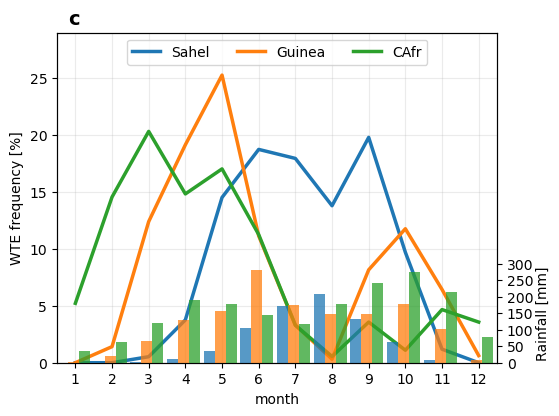

In [6]:
#~ Plot

colors = [list(colors.TABLEAU_COLORS.values())[i] for i in range(len(study_regions_2plot))]

hhhee = Line2D([0], [0], label='WTE freq.', color='k', ls='-')
hrain = Line2D([0], [0], label='Rainfall', color='k', ls='--')


fig_dates, ax_dates = plt.subplots()

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.925)

out_months_rel.index = out_months_rel.index + 0.5

out_months_rel.plot(color=colors, lw=2.5, ax=ax_dates, zorder=100)

ax_dates.text(0.025, 1.025, flabel, weight="bold", fontsize=14, transform=ax_dates.transAxes)

ax_dates.set_xlabel('month')
ax_dates.set_ylim(0., np.ceil(out_months_rel.max().max()+3))
ax_dates.set_ylabel('WTE frequency [%]')  # N
ax_dates.grid(which='major', alpha=0.25) # axis='both')

hs, ls = ax_dates.get_legend_handles_labels()
labels = [reg for reg in out_months.keys()] # + ['Mean']
ax_dates.legend(handles=hs, labels=labels, loc='upper center', ncol=4)

ax_rain = ax_dates.twinx()

i = 0.15
for ireg, reg in enumerate(df_rain.columns):
    ax_rain.bar(df_rain.index+i, df_rain[reg].values, width=0.3, color=colors[ireg], alpha=0.75)
    i=i+0.3

xtcks = np.array(months) + 0.5
ax_rain.set_xticks(xtcks)
ax_rain.set_xticklabels(months)
ax_rain.set_xlim(1, 13)
ax_rain.set_ylabel('Rainfall [mm]')
ax_rain.yaxis.set_label_coords(1.0875, 0.15)
ax_rain.set_yticks(np.arange(0, 300+50, 50))
ax_rain.set_ylim(0., 1000.)

fig_dates.set_size_inches(5.5, 4.)